In [1]:
import numpy as np

In [2]:
def read_number_of_generators(file_name):
    # Reading the number of generators from the uploaded 'scvt.in' file
    with open(file_name, 'r') as file:
        file.readline()  # Skip the first line
        n = int(file.readline().strip())
    print(f'Number of Generators = {n}')
    return n

def allocate_memory(n):
    # Allocating memory for the coordinates array (3D coordinates for each generator)
    return np.zeros((3, n))

def set_random_seed(seed=None):
    # Set the random seed for reproducibility
    np.random.seed(seed)

def get_max_density(max_test=10000):
    # Placeholder for the function to find the maximum density
    # Assuming a uniform distribution for simplicity here
    return 1.0

def random_generator(dens_max):
    # Generate random coordinates based on density (simplified)
    return np.random.random(3) * dens_max

def write_coordinates_to_file(coords, file_name='scvt_mc.dat'):
    # Writing the generated coordinates to a file
    n = coords.shape[1]
    with open(file_name, 'w') as file:
        file.write(f"{n}\n")
        for node in range(n):
            file.write(f"{node + 1} {coords[0, node]:.6f} {coords[1, node]:.6f} {coords[2, node]:.6f}\n")

def main():
    # Main function replicating the Fortran code functionality

    # Step 1: Read the number of generators
    n = read_number_of_generators('/Users/cuibofei/plant_dev/PlantStress/Stress/mesh/cvt/SCVT/scvt.in')

    # Step 2: Allocate memory for the coordinates
    nodes_crd = allocate_memory(n)

    # Step 3: Set the random seed
    set_random_seed(seed=0)  # Using seed=0 for reproducibility

    # Step 4: Get the maximum density
    dens_max = get_max_density()

    # Step 5: Generate coordinates using the Monte Carlo method
    for node in range(n):
        nodes_crd[:, node] = random_generator(dens_max)

    # Step 6: Write the coordinates to file
    write_coordinates_to_file(nodes_crd)

# Running the main function to simulate the process
main()

Number of Generators = 162


In [3]:
# Reading the configuration and initial coordinates from files
def read_config(file_name='scvt.in'):
    with open(file_name, 'r') as file:
        file.readline()  # Skip the first line
        ntemp = int(file.readline().strip())
        # print(f"Number of temperature values = {ntemp}")
        file.readline() 
        max_iter = int(file.readline().strip())

        file.readline() 
        eps = float(file.readline().strip())

        file.readline() 
        ip = int(file.readline().strip())

        file.readline() 
        istride = int(file.readline().strip())
    return ntemp, max_iter, eps, ip, istride

def read_initial_coordinates(file_name='scvt_s.dat', nmax=100000):
    x, y, z = [], [], []
    with open(file_name, 'r') as file:
        n = int(file.readline().strip())
        if n >= nmax:
            raise ValueError(f"The number of generators must be less than {nmax}")
        for _ in range(n):
            _, x_val, y_val, z_val = map(float, file.readline().split())
            x.append(x_val)
            y.append(y_val)
            z.append(z_val)
    return n, np.array(x), np.array(y), np.array(z)

def lloyd_algorithm(n, x, y, z, max_iter, eps, istride, ip):
    # If the North or South pole is fixed, adjust the pole node
    indx = None
    if ip != 0:
        distmin = 1000000.0
        for node in range(n):
            dist = abs(x[node]) + abs(y[node]) + abs(z[node] - ip * 1.0)
            if dist < distmin:
                distmin = dist
                indx = node
        x[indx], y[indx], z[indx] = 0.0, 0.0, ip * 1.0
        print("The North Pole is fixed!")

    for iloop in range(1, max_iter + 1):
        if (iloop - 1) % istride == 0:
            print(f"A re-triangulation is done in iteration {iloop}!")
            # Placeholder for re-triangulation (grid function)

        # Lloyd's algorithm main loop
        dm_LI, dm_L2 = 0.0, 0.0
        for node in range(n):
            # Update the node's position (simplified for demonstration)
            centroid_x, centroid_y, centroid_z = np.mean([x, y, z], axis=1)
            new_pos = np.array([centroid_x, centroid_y, centroid_z]) / np.linalg.norm([centroid_x, centroid_y, centroid_z])

            # Compute distance moved
            dm = np.linalg.norm(np.array([x[node], y[node], z[node]]) - new_pos)
            dm_L2 += dm ** 2
            if dm > dm_LI:
                dm_LI = dm

            # Update positions
            if node != indx:  # Don't move fixed node
                x[node], y[node], z[node] = new_pos

        dm_L2 = np.sqrt(dm_L2 / n)
        if dm_LI < eps:
            break

    return x, y, z, iloop, dm_LI

def write_final_coordinates(x, y, z, file_name='scvt_lloyd.dat'):
    n = len(x)
    with open(file_name, 'w') as file:
        file.write(f"{n}\n")
        for node in range(n):
            file.write(f"{node + 1:10d} {x[node]:16.10f} {y[node]:16.10f} {z[node]:16.10f}\n")
    print("Final coordinates written to 'scvt_lloyd.dat'.")

def main():
    # Step 1: Read config from 'scvt.in'
    ntemp, max_iter, eps, ip, istride = read_config(file_name='/Users/cuibofei/plant_dev/PlantStress/Stress/mesh/cvt/SCVT/scvt.in')

    # Step 2: Read initial generator coordinates from 'scvt_s.dat'
    n, x, y, z = read_initial_coordinates(file_name='/Users/cuibofei/plant_dev/PlantStress/Stress/mesh/cvt/SCVT/py_version/scvt_s.dat')

    # Step 3: Run Lloyd's algorithm
    x, y, z, iloop, dm_LI = lloyd_algorithm(n, x, y, z, max_iter, eps, istride, ip)

    # Step 4: Write final coordinates to file
    write_final_coordinates(x, y, z)

# Running the main function to simulate Lloyd's algorithm
main()

A re-triangulation is done in iteration 1!
A re-triangulation is done in iteration 2!
A re-triangulation is done in iteration 3!
A re-triangulation is done in iteration 4!
A re-triangulation is done in iteration 5!
A re-triangulation is done in iteration 6!
A re-triangulation is done in iteration 7!
A re-triangulation is done in iteration 8!
Final coordinates written to 'scvt_lloyd.dat'.


In [4]:
import numpy as np
from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt


In [3]:

# Constants
NMAX = 1000000

# Arrays for nodal coordinates
X = np.zeros(NMAX, dtype=float)
Y = np.zeros(NMAX, dtype=float)
Z = np.zeros(NMAX, dtype=float)

# Plot size
PLTSIZ = 7.5

# Function to perform Delaunay triangulation (replaces TRMESH)
def delaunay_triangulation(X, Y, Z, N):
    points = np.column_stack((X[:N], Y[:N]))  # Combine X and Y coordinates
    tri = Delaunay(points)  # Perform Delaunay triangulation
    return tri

# Function to print triangulation info (replaces TRPRNT)
def print_triangulation_info(tri, X, Y, Z, output_file):
    simplices = tri.simplices  # Get the triangles (indices of points)
    with open(output_file, 'w') as f:
        for simplex in simplices:
            # Get the 3 points of the triangle
            p1, p2, p3 = simplex
            f.write(f"Triangle: ({X[p1]}, {Y[p1]}, {Z[p1]}) - "
                    f"({X[p2]}, {Y[p2]}, {Z[p2]}) - ({X[p3]}, {Y[p3]}, {Z[p3]})\n")

# Function to create Voronoi diagram (replaces CRLIST and VRPLOT)
def voronoi_diagram(X, Y, Z, N, plot_file):
    points = np.column_stack((X[:N], Y[:N]))  # Combine X and Y coordinates
    vor = Voronoi(points)  # Create Voronoi diagram
    
    # Plot Voronoi diagram
    fig, ax = plt.subplots()
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='blue')
    plt.savefig(plot_file)
    plt.close()

# Load data from file (simulate node input)
with open('/Users/cuibofei/plant_dev/PlantStress/Stress/mesh/cvt/SCVT/py_version/nodes.dat', 'r') as f:
    N = int(f.readline().strip())
    for node in range(N):
        k, x, y, z = map(float, f.readline().strip().split())
        X[node] = x
        Y[node] = y
        Z[node] = z

# Perform Delaunay triangulation
tri = delaunay_triangulation(X, Y, Z, N)

# Output triangulation info
print_triangulation_info(tri, X, Y, Z, 'triangulation_output.txt')

# Create and save Voronoi diagram
voronoi_diagram(X, Y, Z, N, 'voronoi_output.png')

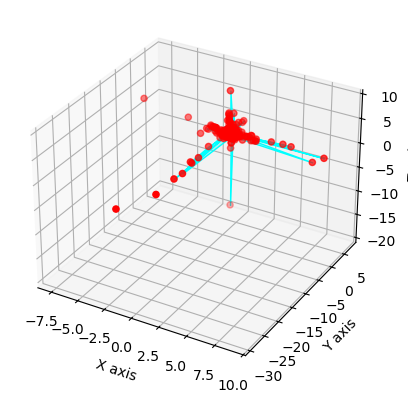

In [6]:
import numpy as np
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Constants
NMAX = 1000000

# Arrays for nodal coordinates
X = np.zeros(NMAX, dtype=float)
Y = np.zeros(NMAX, dtype=float)
Z = np.zeros(NMAX, dtype=float)

# Function to create 3D Voronoi diagram
def voronoi_diagram_3d(X, Y, Z, N, plot_file):
    points = np.column_stack((X[:N], Y[:N], Z[:N]))  # Combine X, Y, Z coordinates
    vor = Voronoi(points)  # Create Voronoi diagram

    # Set up 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot Voronoi vertices
    ax.scatter(vor.vertices[:, 0], vor.vertices[:, 1], vor.vertices[:, 2], color='r')

    # Plot Voronoi regions (cells)
    for region in vor.regions:
        if not -1 in region and len(region) > 0:  # Exclude infinite regions
            polygon = [vor.vertices[i] for i in region]
            ax.add_collection3d(Poly3DCollection([polygon], color='cyan', alpha=0.3))

    # Plot the points
    ax.scatter(X[:N], Y[:N], Z[:N], color='b')

    # Set plot labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    # Save plot
    plt.savefig(plot_file)
    plt.show()

# Load data from file (simulate node input)
with open('/Users/cuibofei/plant_dev/PlantStress/Stress/mesh/cvt/SCVT/py_version/scvt_s.dat', 'r') as f:
    N = int(f.readline().strip())
    for node in range(N):
        k, x, y, z = map(float, f.readline().strip().split())
        X[node] = x
        Y[node] = y
        Z[node] = z

# Create and save 3D Voronoi diagram
voronoi_diagram_3d(X, Y, Z, N, 'voronoi_3d_output.png')